# Deep Learning Workflow

## Hangar

In [1]:
!pip install grpcio>=1.21.1
!pip install git+https://github.com/tensorwerk/hangar-py
!pip install matplotlib

  Cloning https://github.com/tensorwerk/hangar-py to /tmp/pip-req-build-xpwqb0h3
  Running command git clone -q https://github.com/tensorwerk/hangar-py /tmp/pip-req-build-xpwqb0h3
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmuptmyn/wheels/41/92/9e/a01c44b33015b54b966237badb395ec6ff104b78676e83c1aa
Successfully built hangar


In [2]:
from hangar import Repository

import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
!mkdir myhangarrepo
repo = Repository(path='myhangarrepo')
repo.init(user_name='Sherin Thomas', user_email='sherin@gmail.com', remove_old=True)

mkdir: cannot create directory ‘myhangarrepo’: File exists
Hangar Repo initialized at: myhangarrepo/__hangar


'myhangarrepo/__hangar'

In [4]:
repo

            
 Hangar Repository            
     Repository Path  : myhangarrepo/__hangar            
     Writer-Lock Free : True


In [5]:
repo.writer_lock_held
repo.repo_path

'myhangarrepo'

In [6]:
# data link
# https://drive.google.com/drive/folders/1zYdhNN4s5QnqGHRN632hXvfCt4OxsF0l?usp=sharing

In [7]:
datapath = "mnist_data"
import os
os.listdir(datapath)


['data1.npy', 'target1.npy', 'data2.npy', 'target2.npy']

In [8]:
target = np.load(os.path.join(datapath, 'target1.npy'))
data = np.load(os.path.join(datapath, 'data1.npy'))

In [9]:
data.shape, target.shape

((60000, 28, 28), (60000,))

In [10]:
co = repo.checkout(write=True)

In [11]:
data_dset = co.datasets.init_dataset('mnist_data', shape=(28, 28), dtype='uint8')

Dataset Specification:: Name: `mnist_data`, Initialization style: `provided`, Shape: `(28, 28)`, DType: `uint8`, Samples Named: `True`, Variable Shape: `False`, Max Shape: `(28, 28)`
Dataset Initialized: `mnist_data`


In [12]:
co.datasets['mnist_data'] == data_dset

True

In [13]:
target_dset = co.datasets.init_dataset('mnist_target', prototype=target[0])

Dataset Specification:: Name: `mnist_target`, Initialization style: `prototype`, Shape: `()`, DType: `int64`, Samples Named: `True`, Variable Shape: `False`, Max Shape: `()`
Dataset Initialized: `mnist_target`


In [14]:
co.commit('datasets init')
co.close()

Commit operation requested with message: datasets init
(437, 228, 437)
removing all stage hash records
Commit completed. Commit hash: 7244400052f8d27d31f0431fc8238a195d5bada4
writer checkout of master closed


In [15]:
co = repo.checkout(write=True)
data_dset = co.datasets['mnist_data']
target_dset = co.datasets['mnist_target']

In [16]:
with data_dset, target_dset:  # You don't really need this CM if you are not worried about perf
  for i in tqdm(range(len(data))):
    sample_name = str(i)
    data_dset[sample_name] = data[i]
    target_dset[sample_name] = np.array(target[i])
co.commit('dataset curation: stage 1')
co.close()

100%|██████████| 60000/60000 [00:14<00:00, 4226.50it/s]


Commit operation requested with message: dataset curation: stage 1
(7658229, 1876692, 65536)
removing all stage hash records
Commit completed. Commit hash: 9a599a00e6a5a9815224f1a06bf13803b257ee52
writer checkout of master closed


In [17]:
co = repo.checkout()
dset = co.datasets['mnist_data']

 * Checking out BRANCH: master with current HEAD: 9a599a00e6a5a9815224f1a06bf13803b257ee52


In [18]:
'1' in dset

True

In [19]:
dset.keys()

<generator object DatasetDataReader.keys at 0x7f7461fcfde0>

In [20]:
next(dset.values()).shape

(28, 28)

In [21]:
dset


 Hangar DatasetDataReader                 
    Dataset Name     : mnist_data                
    Schema UUID      : ec9663cc944f11e9aeb3eb735c65f17e                
    Schema Hash      : ed0767935a22                
    Variable Shape   : False                
    (max) Shape      : (28, 28)                
    Datatype         : <class 'numpy.uint8'>                
    Named Samples    : True                
    Access Mode      : r                
    Num Samples      : 60000


0


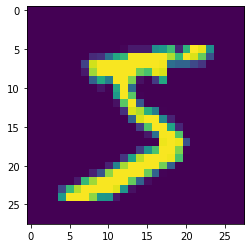

In [22]:
for key, value in dset.items():
    print(key)
    plt.imshow(value)
    break

In [23]:
repo.log()

* 9a599a00e6a5a9815224f1a06bf13803b257ee52 (master) : dataset curation: stage 1
* 7244400052f8d27d31f0431fc8238a195d5bada4 : datasets init


In [24]:
del dset['1']

TypeError: 'DatasetDataReader' object does not support item deletion

### Metadata

In [25]:
co = repo.checkout(write=True)
co.metadata['DataSource'] = "Sherin"
co.commit("Added source")
co.close()

Commit operation requested with message: Added source
(7658294, 1876746, 65536)
removing all stage hash records
Commit completed. Commit hash: 45a8a990eedb268b5a343bfc9257154ff1ccf25c
writer checkout of master closed


### Safety from python "oddities" is built in Hangar's very essense.

In [26]:
co = repo.checkout(write=True)
data_dset = co.datasets['mnist_data']
co.close()
data_dset['1']

writer checkout of master closed


ReferenceError: weakly-referenced object no longer exists

### What you put in is what you get out
All data is hashed by cryptographically secure hash algorithms (blake2b with 20byte digest length)
A commit is entirely self sufficient, and it's hash depends on the hash of previous references
For performance reasons, data hash is only calculated / verified when:

a sample is added to a dataset
data is fetched from a remote repo
data is sent to a remote repo
During regular read access, data integrity is ensured via fletcher32 / crc32 checksums

Backend store utilities provide well validated, trusted, and performant implementations

## Branching & Merging
- Time travel through the historical evolution of a dataset
- Zero-cost Branching to enable exploratory analysis and collaboration
- Cheap Merging to build datasets over time (with multiple collaborators)
- Completely abstracted organization and management of data files on disk
- Ability to only retrieve a small portion of the data (as needed) while still maintaining complete historical record
- Ability to push and pull changes directly to collaborators or a central server (ie a truly distributed version control system)

In [29]:
repo.create_branch('stage2')

'stage2'

In [30]:
co2 = repo.checkout(branch_name='stage2', write=True)

In [31]:
target = np.load(os.path.join(datapath, 'target2.npy'))
data = np.load(os.path.join(datapath, 'data2.npy'))
target.shape, data.shape

((10000,), (10000, 28, 28))

In [32]:
with co2.datasets['mnist_data'] as ddset, co2.datasets['mnist_target'] as tdset:
    current_index = len(ddset)
    for i in tqdm(range(len(data))):
        sample_name = str(current_index + i)
        ddset[sample_name] = data[i]
        tdset[sample_name] = np.array(target[i])
co2.metadata['DataSource'] = "Somebody else"
co2.commit('Data curation: stage2')
co2.close()

100%|██████████| 10000/10000 [00:02<00:00, 4242.30it/s]


Commit operation requested with message: Data curation: stage2
(8938294, 2189342, 65536)
removing all stage hash records
Commit completed. Commit hash: 529cded99cf7425ec9341bc9f8dd17402220f8e2
writer checkout of stage2 closed


In [33]:
repo.list_branch_names()

['master', 'stage2']

In [34]:
repo.log(branch_name='stage2')

* 529cded99cf7425ec9341bc9f8dd17402220f8e2 (stage2) : Data curation: stage2
* 45a8a990eedb268b5a343bfc9257154ff1ccf25c (master) : Added source
* 9a599a00e6a5a9815224f1a06bf13803b257ee52 : dataset curation: stage 1
* 7244400052f8d27d31f0431fc8238a195d5bada4 : datasets init


In [35]:
co = repo.checkout(write=True)

In [36]:
# Dummy commit to make the diversion
co.metadata['RandomeKey'] = "RandomValue"
co.commit("Dummy metadata")

Commit operation requested with message: Dummy metadata
(7658351, 1876789, 65536)
removing all stage hash records
Commit completed. Commit hash: cab1492751e1f5bb202c36a175f442e53d6e23cf


'cab1492751e1f5bb202c36a175f442e53d6e23cf'

In [37]:
# It's not a good idea to run this now
# from pprint import pprint
# pprint(co.diff.branch("stage2"))

In [38]:
co.merge("Merging stage2", dev_branch='stage2')

Selected 3-Way Merge Strategy
(8938351, 2189381, 65536)
removing all stage hash records


'baf680d7e5ff9cd3ebc5ccb18aa87e6344d0d331'

In [39]:
co.close()

writer checkout of master closed


In [40]:
repo.log()

*   baf680d7e5ff9cd3ebc5ccb18aa87e6344d0d331 (master) : Merging stage2
|\  
* | cab1492751e1f5bb202c36a175f442e53d6e23cf : Dummy metadata
| * 529cded99cf7425ec9341bc9f8dd17402220f8e2 (stage2) : Data curation: stage2
|/  
* 45a8a990eedb268b5a343bfc9257154ff1ccf25c : Added source
* 9a599a00e6a5a9815224f1a06bf13803b257ee52 : dataset curation: stage 1
* 7244400052f8d27d31f0431fc8238a195d5bada4 : datasets init


In [41]:
repo._details()


Branch
File Size: 32.77 kB

b'branch:master' b'baf680d7e5ff9cd3ebc5ccb18aa87e6344d0d331'
b'branch:stage2' b'529cded99cf7425ec9341bc9f8dd17402220f8e2'
b'head' b'branch:master'
b'writerlock:' b'LOCK_AVAILABLE'

Label
File Size: 28.67 kB

b'h:0aebb413657b336278caf6c6c16ff7f82f51d847' b'Sherin'
b'h:62117c1d7e38b36756574d88ace2ec7931b1203f' b'RandomValue'
b'h:b8250b35c6f24d3fd77c1a77117f18021d5026f7' b'Somebody else'

HASH
File Size: 16.65 MB

b'h:0000b8a4c5c44ed62bd74f5f434ca73af2b20ad5' b'ed0767935a22 000 $ 77 346 * 28 28'
b'h:0000daa96823de7a350454a4ee102e2a25db3ef9' b'ed0767935a22 002 $ 0 469 * 28 28'
b'h:0000ee5d2023878fcc25b727a76532dc5284c8fb' b'ed0767935a22 000 $ 10 83 * 28 28'
b'h:0003b87e9b75821f8a33216d7c2c944a148ed03a' b'ed0767935a22 000 $ 47 390 * 28 28'
b'h:00047a8293468b6147f74550ca45c996b0c4028c' b'ed0767935a22 000 $ 43 176 * 28 28'
b'h:0005f048fd5d8ae38556caa5b950cf9078998f01' b'ed0767935a22 000 $ 68 351 * 28 28'
b'h:0008b4e88a0d7862e59df3f786a469c88a25b6f5' b'ed0767935a22

FileNotFoundError: Cannot query size of: /tmp/tmph80kd1s3/9a599a00e6a5a9815224f1a06bf13803b257ee52.lmdb. File does not exist

In [ ]:
repo.summary()

In [ ]:
# What's pending -> Remote Hangar Repository

## PyTorch
- Dynamic Graph
- torch.nn
- Datasets & Dataloaders
- Training
    - Autograd
    - Optimization
- Validation
- Serializing

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Dynamic Graph

### torch.nn

In [44]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [52]:
model.train()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

### Datasets & Dataloaders

In [53]:
from torch.utils.data import Dataset, DataLoader

In [60]:
class HangarDataset(Dataset):
    """
    PyTorch Dataset that gives access to hangar dataset
    """

    def __init__(self, data, target):
        if len(data) != len(target):
            raise RuntimeError("Length of data and target does not match")
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, key):
        """
        Since our sample names in hangar repository is str(index),
        we can do str(key) to figure out the sample name
        """
        print('----------------------', key)
        sample_name = str(key)
        return self.data[sample_name], self.target[sample_name]

In [86]:
co = repo.checkout()
ddset = co.datasets['mnist_data']
tdset = co.datasets['mnist_target']
hangar_dset = HangarDataset(ddset, tdset)

 * Checking out BRANCH: master with current HEAD: baf680d7e5ff9cd3ebc5ccb18aa87e6344d0d331


In [87]:
hangar_dset[66138]

---------------------- 66138


(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 216, 253, 153,
           0,   0,   0,   0,   0,  45, 229, 253,  13,   0,   0,   0,   0,
           0

In [88]:
hangar_dataloader = DataLoader(hangar_dset, batch_size=4, shuffle=True, num_workers=4)

### Training

In [89]:
for data, target in hangar_dataloader:
    print(data.shape, target.shape)

---------------------- 45876
---------------------- 800
---------------------- 69824
---------------------- 68207
---------------------- 69784
---------------------- 43437
---------------------- 7750
---------------------- 15143
---------------------- 66975
---------------------- 15138
---------------------- 53832
---------------------- 41824
---------------------- 42444
---------------------- 18204
---------------------- 65251
---------------------- 15195
---------------------- 55980
---------------------- 27781
---------------------- 4217
---------------------- 49291
---------------------- 4390
---------------------- 48573
---------------------- 2904
---------------------- 19827
---------------------- 28933
---------------------- 31854
---------------------- 47113
---------------------- 18744
---------------------- 26805
---------------------- 46153
---------------------- 55059
---------------------- 28999
---------------------- 22791
---------------------- 20405
--------------------

OSError: Traceback (most recent call last):
  File "/home/hhsecond/anaconda3/envs/dlblr/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hhsecond/anaconda3/envs/dlblr/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-60-5f90c7639282>", line 22, in __getitem__
    return self.data[sample_name], self.target[sample_name]
  File "/home/hhsecond/anaconda3/envs/dlblr/lib/python3.7/site-packages/hangar/dataset.py", line 118, in __getitem__
    return self.get(key)
  File "/home/hhsecond/anaconda3/envs/dlblr/lib/python3.7/site-packages/hangar/dataset.py", line 279, in get
    data = self._fs.read_data(hashVal, self._mode, self._schema_dtype_num)
  File "/home/hhsecond/anaconda3/envs/dlblr/lib/python3.7/site-packages/hangar/hdf5_store.py", line 538, in read_data
    self.rHands[fSchema][fInstance][dsetCol].read_direct(destArr, srcSlc, destSlc)
  File "/home/hhsecond/anaconda3/envs/dlblr/lib/python3.7/site-packages/h5py/_hl/dataset.py", line 733, in read_direct
    self.id.read(mspace, fspace, dest, dxpl=self._dxpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5d.pyx", line 181, in h5py.h5d.DatasetID.read
  File "h5py/_proxy.pyx", line 130, in h5py._proxy.dset_rw
  File "h5py/_proxy.pyx", line 84, in h5py._proxy.H5PY_H5Dread
OSError: Can't read data (data error detected by Fletcher32 checksum)


---------------------- 49775
---------------------- 21816
---------------------- 31791
---------------------- 57339
---------------------- 8538
---------------------- 18225
---------------------- 50376
---------------------- 66470
---------------------- 46180
---------------------- 60069
---------------------- 24195
---------------------- 6094
